In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,Dataset

In [2]:
x = torch.linspace(0, 799, 800)
x.shape,x.max(),x.min()

(torch.Size([800]), tensor(799.), tensor(0.))

In [3]:
y = torch.sin(x*2*3.1416/40)
y.shape, y.max(), y.min()

(torch.Size([800]), tensor(1.), tensor(-1.))

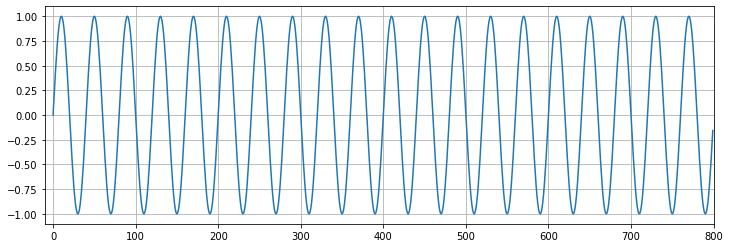

In [4]:
plt.figure(figsize = (12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())
plt.show()

In [5]:
test_size = 40
train_set = y[:-test_size]
test_set =  y[-test_size : ]

train_set.shape, test_set.shape

(torch.Size([760]), torch.Size([40]))

In [6]:
def input_data(seq, ws):

    out = []
    L = len(seq)
    #print(np.array(L))

    for i in range(L - ws):
        
        # Burası x Değeri gibi düşün
        window = seq[i : i+ws]
        
        # Burası y Değeri gibi düşün
        label = seq[i+ws:i+ws+1]

        out.append((window,label))

    return out

In [7]:
input_data(seq = [1,2,3,4,5], ws = 2)

[([1, 2], [3]), ([2, 3], [4]), ([3, 4], [5])]

In [8]:
window_size = 40

train_data = input_data(seq = train_set, ws = window_size)

(train_data[0][0].shape),(train_data[0][1].shape)

(torch.Size([40]), torch.Size([1]))

In [9]:
# 0 - 799 ---> 800
# 800 - 40 ---> 760
# 760 - 40 ---> 720

len(train_data)

720

In [10]:
class LSTM(nn.Module):

    def __init__(self, input_size = 1 , hidden_size = 50, out_size = 1):

        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size , hidden_size)

        self.linear = nn.Linear(hidden_size, out_size)

        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1, hidden_size))

    def forward(self, seq):

        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)

        pred = self.linear(lstm_out.view(len(seq), -1))

        # Son değeri yakalıyoruz !!!
        return pred[-1]


In [11]:
train_set.shape, train_set.view(len(train_set), 1, -1).shape, train_set.view(len(train_set),-1).shape

(torch.Size([760]), torch.Size([760, 1, 1]), torch.Size([760, 1]))

In [12]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [13]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [14]:
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


In [15]:
model(torch.FloatTensor([1,2,3,4]))

tensor([-0.1684], grad_fn=<SelectBackward0>)

In [16]:
for i,(seq,train) in enumerate(train_data):
    print(seq.shape, train.shape)
    if i == 3 :
        break

torch.Size([40]) torch.Size([1])
torch.Size([40]) torch.Size([1])
torch.Size([40]) torch.Size([1])
torch.Size([40]) torch.Size([1])


In [17]:
# Train_set , Test_set farklı !!
len(train_data)

720

In [18]:
model.hidden_size,window_size

(50, 40)

In [19]:
train_set.shape

torch.Size([760])

In [20]:
len(train_set[-window_size:].tolist())

40

Epochs :    0, Loss : 0.0921
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.6071590185165405


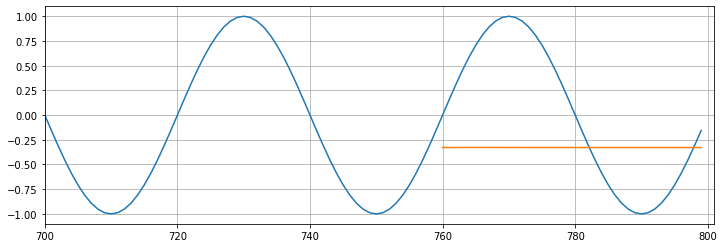

Epochs :    1, Loss : 0.0651
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.5650987029075623


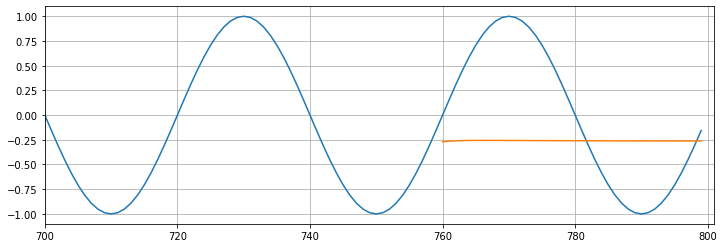

Epochs :    2, Loss : 0.0420
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.5199716687202454


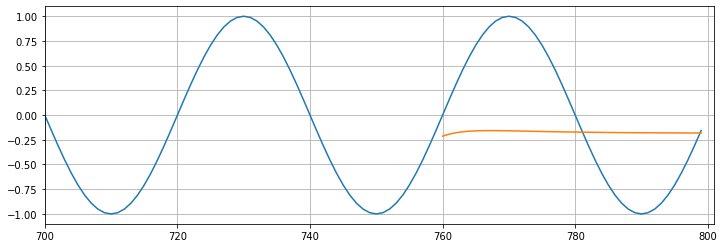

Epochs :    3, Loss : 0.0178
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.42209967970848083


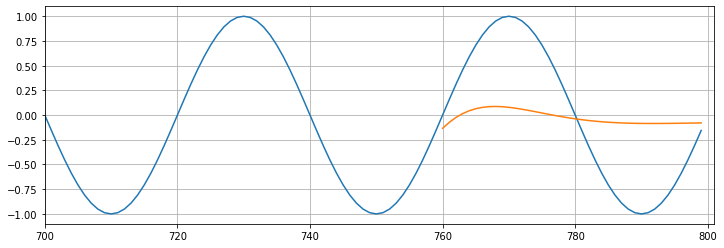

Epochs :    4, Loss : 0.0029
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.16624125838279724


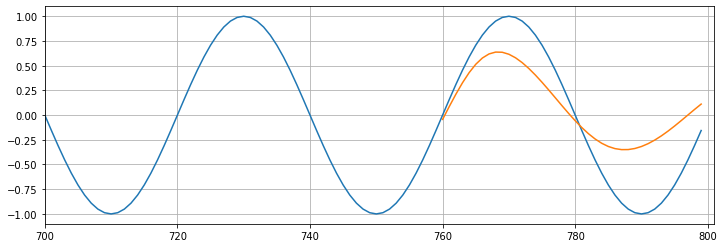

Epochs :    5, Loss : 0.0003
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.030554424971342087


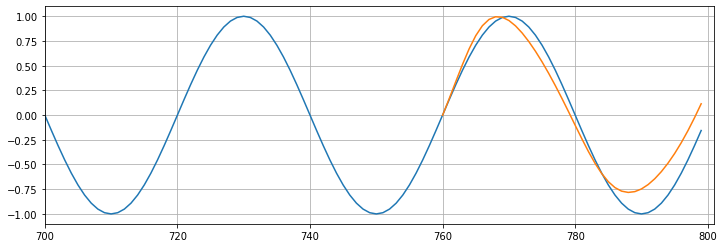

Epochs :    6, Loss : 0.0001
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.014990185387432575


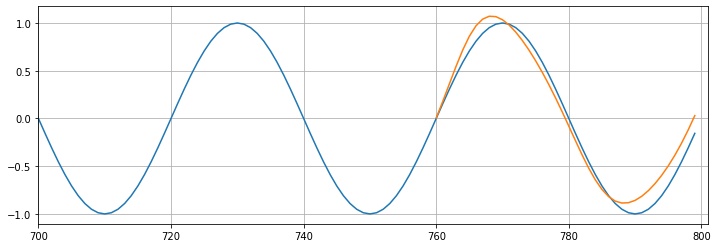

Epochs :    7, Loss : 0.0001
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.01185668632388115


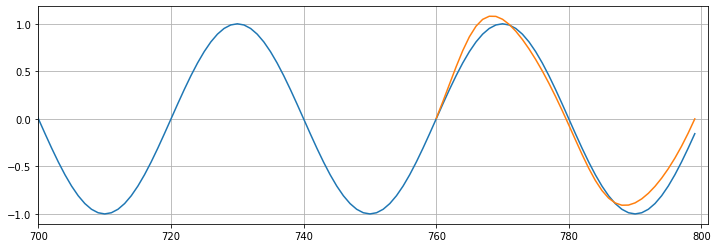

Epochs :    8, Loss : 0.0001
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.010163827799260616


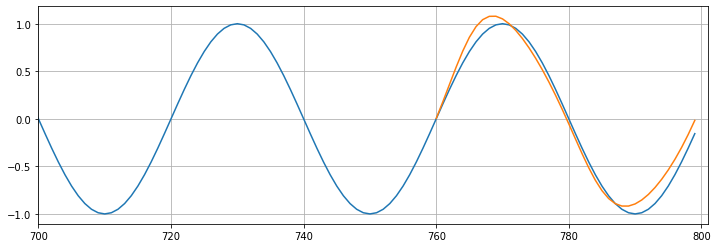

Epochs :    9, Loss : 0.0001
Train Set Preds Shape :  (40,)
Append Preds Shape :  (80,)
Performance On Test Range : 0.008897590450942516


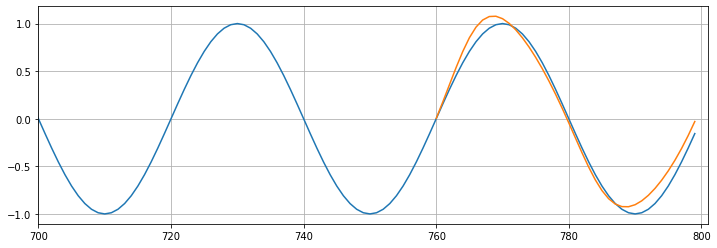

In [21]:
import time

epochs = 10
future = 40

for i in range(epochs):

    # Burda model eğitiliyor !!!
    # Train_data bu unutma !!!
    for seq,y_train in train_data:

        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()

    print(f"Epochs : {i:4}, Loss : {loss.item():.4f}")


    # Train_set ile train_data dikkat et !! Karıştırma !!
    ###
    # Bu son preds yani şöyle normalde bizim train_set yani 760 değere sahip bir değer
    # Biz burdan son 40 değerini alıyoruz yani preds değerini shape = 40 oluyor train_set olarak 720 değer geride kalıyor
    # Bizim bu sahip olmuş olduğumuz 40 değerin üstüne 40 future daha ekliyoruz ve 80 preds sahip oluyoruz 
    # Burda sahip olmuş olduğumuz 80 değerin son 40 tahmin değerinden gelme yani model den gelme !!!
    # 720 + 80 = 800 oluyor

    preds = train_set[-window_size:].tolist()
    print("Train Set Preds Shape : ", np.array(preds).shape)

    for f in range(future):
        
        # 40 değer var train'den gelen !!!
        seq = torch.FloatTensor(preds[-window_size:])

        with torch.no_grad():

            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            
            preds.append(model(seq).item())

    print("Append Preds Shape : ", np.array(preds).shape)

    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance On Test Range : {loss}")

    plt.figure(figsize = (12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800), preds[window_size:])
    plt.show()

In [22]:
epochs = 15
window_size = 40
future = 40

all_data = input_data(y,window_size)
len(all_data)

760

In [23]:
for i,(seq,train) in enumerate(all_data):
    print(seq.shape, train.shape)
    if i == 3 :
        break

torch.Size([40]) torch.Size([1])
torch.Size([40]) torch.Size([1])
torch.Size([40]) torch.Size([1])
torch.Size([40]) torch.Size([1])


In [24]:
import time

start_time = time.time()

for i in range(epochs):

    # Burda model eğitiliyor !!!
    # Train_data bu unutma !!!
    for seq,y_train in all_data:

        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch : {i:4}, Loss : {loss.item()}")


total_time = time.time() - start_time

print()
print(f"{total_time / 60} minutes .. ")

Epoch :    0, Loss : 0.00013452964776661247
Epoch :    1, Loss : 0.00013443079660646617
Epoch :    2, Loss : 0.00013231823686510324
Epoch :    3, Loss : 0.0001287955674342811
Epoch :    4, Loss : 0.00012434150266926736
Epoch :    5, Loss : 0.00011931319022551179
Epoch :    6, Loss : 0.00011398040078347549
Epoch :    7, Loss : 0.00010853933781618252
Epoch :    8, Loss : 0.00010312719678040594
Epoch :    9, Loss : 9.784108260646462e-05
Epoch :   10, Loss : 9.274225158151239e-05
Epoch :   11, Loss : 8.787676779320464e-05
Epoch :   12, Loss : 8.325899398187175e-05
Epoch :   13, Loss : 7.890000415500253e-05
Epoch :   14, Loss : 7.480428030248731e-05

3.6557515462239586e-07 minutes .. 


# Forecast Into Unknown Future

In [25]:
preds = y[-window_size :].tolist()

for i in range(future):

    seq = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():

        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

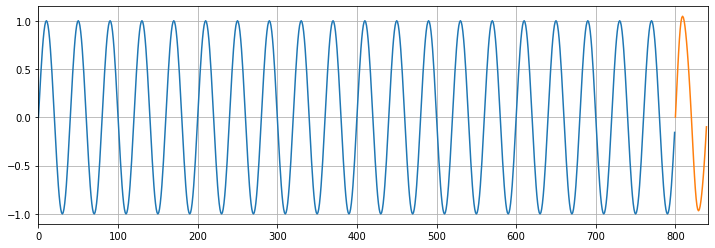

In [26]:
plt.figure(figsize = (12,4))
plt.xlim(0,841)
plt.grid(True)
plt.plot(y.numpy())

# Plotting ForeCast
plt.plot(range(800,800+future), preds[window_size:])
plt.show()

---

# RNN On A Time Series 

In [27]:
from google.colab import drive
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
path = "/content/drive/MyDrive/PyTorch/Data/TimeSeriesData/Alcohol_Sales.csv"
df = pd.read_csv(path,parse_dates = True,index_col = 0)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [29]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [30]:
df.isnull().sum()

S4248SM144NCEN    0
dtype: int64

In [31]:
print("Before : ",len(df))
df = df.dropna()
print("After : ", len(df))

Before :  325
After :  325


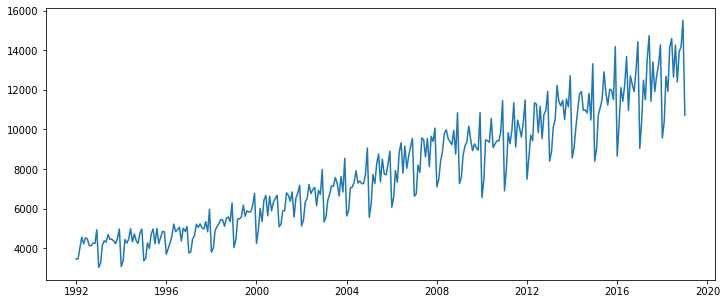

In [32]:
plt.figure(figsize=(12,5))
# df.plot(figsize = (12,5))
plt.plot(df.iloc[:,0])
plt.show()

In [33]:
y = df["S4248SM144NCEN"].values.astype(float)
y.shape

(325,)

In [34]:
test_size = 12
train_set = y[:-test_size] 
test_set = y[-test_size:]

train_set.shape , test_set.shape

((313,), (12,))

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler(feature_range = (-1,1))

In [37]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [38]:
train_norm = scaler.transform(train_set.reshape(-1,1))
train_norm.min(), train_norm.max()

(-1.0, 1.0)

In [39]:
len(y) - test_size

313

In [40]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm.shape

torch.Size([313])

In [41]:
window_size = 12
def input_data(seq,ws):

    out = []
    L = len(seq)

    for i in range(L - ws):
        window = seq[i : i+ws]
        label = seq[i+ws : i+ws+1]
        out.append((window,label))

    return out

In [42]:
train_data = input_data(train_norm, window_size)

In [43]:
len(train_data)

301

In [44]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

In [45]:
for i,(seq,train) in enumerate(train_data):
    
    print(seq.shape, train.shape)
    if i == 3:
        break

torch.Size([12]) torch.Size([1])
torch.Size([12]) torch.Size([1])
torch.Size([12]) torch.Size([1])
torch.Size([12]) torch.Size([1])


In [46]:
class LSTMnetwork(nn.Module):

    def __init__(self, input_size = 1, hidden_size = 100, output_size = 1 ):

        super().__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size , hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))
        
    def forward(self,seq):

        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)

        pred = self.linear(lstm_out.view(len(seq),-1))

        return pred[-1]

In [47]:
torch.zeros(1,1,50)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]])

In [48]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [49]:
epochs = 100

import time

start_time = time.time()


for epoch in range(epochs):

    for seq, y_train in train_data:

        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()


    print(f"Epoch : {epoch:4}, Loss : {loss.item()}")

total_time = time.time() - start_time

print()
print(f"Total Time : {total_time / 60} minutes ..")

Epoch :    0, Loss : 0.25310197472572327
Epoch :    1, Loss : 0.37531983852386475
Epoch :    2, Loss : 0.39027222990989685
Epoch :    3, Loss : 0.34934669733047485
Epoch :    4, Loss : 0.3308565020561218
Epoch :    5, Loss : 0.33229973912239075
Epoch :    6, Loss : 0.32670360803604126
Epoch :    7, Loss : 0.3207411766052246
Epoch :    8, Loss : 0.3065352737903595
Epoch :    9, Loss : 0.29518023133277893
Epoch :   10, Loss : 0.26934343576431274
Epoch :   11, Loss : 0.25998449325561523
Epoch :   12, Loss : 0.2466583251953125
Epoch :   13, Loss : 0.2240382879972458
Epoch :   14, Loss : 0.18602679669857025
Epoch :   15, Loss : 0.1856096386909485
Epoch :   16, Loss : 0.17209307849407196
Epoch :   17, Loss : 0.25161734223365784
Epoch :   18, Loss : 0.22557584941387177
Epoch :   19, Loss : 0.1744897961616516
Epoch :   20, Loss : 0.2023598700761795
Epoch :   21, Loss : 0.20818661153316498
Epoch :   22, Loss : 0.16646955907344818
Epoch :   23, Loss : 0.17595747113227844
Epoch :   24, Loss : 0.1

In [50]:
future = 12
preds = train_norm[-window_size: ].tolist()

model.eval()

for i in range(future):

    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():

        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

In [51]:
len(preds)

24

In [52]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
true_predictions

array([[10408.94905812],
       [12883.22327685],
       [11171.11894929],
       [13773.23850366],
       [14649.08534095],
       [11199.92920506],
       [14581.80562565],
       [11538.54105854],
       [13429.71337053],
       [12627.23206294],
       [12548.68234682],
       [10371.16994017]])

In [53]:
df["S4248SM144NCEN"][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [54]:
x = np.arange("2018-02-01","2019-02-01",dtype = "datetime64[M]")
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [55]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

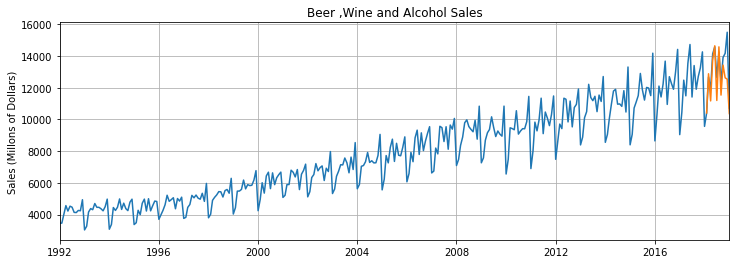

In [56]:
plt.figure(figsize = (12,4))
plt.title("Beer ,Wine and Alcohol Sales")
plt.ylabel("Sales (Millons of Dollars)")
plt.grid(True)

plt.autoscale(axis = "x", tight = True)
plt.plot(df["S4248SM144NCEN"])
plt.plot(x,true_predictions)
plt.show()

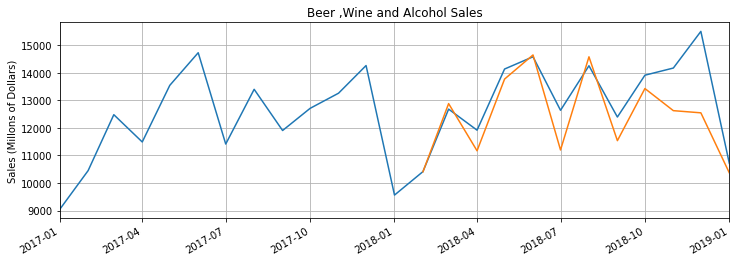

In [57]:
fig = plt.figure(figsize = (12,4))
plt.title("Beer ,Wine and Alcohol Sales")
plt.ylabel("Sales (Millons of Dollars)")
plt.grid(True)
plt.autoscale(axis = "x", tight = True)
fig.autofmt_xdate()

plt.plot(df["S4248SM144NCEN"]["2017-01-01":])
plt.plot(x,true_predictions)
plt.show()

In [58]:
epochs = 100

model.train()

y_norm = scaler.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size)

import time
start_time = time.time()

for epoch in range(epochs):

    for seq, y_train in all_data:

        optimizer.zero_grad()

        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch : {epoch+1:2}, Loss : {loss.item():10.8f}")

print(f"\nDuration : {time.time()-start_time:.0f} seconds")

Epoch :  1, Loss : 0.02874834
Epoch :  2, Loss : 0.01326633
Epoch :  3, Loss : 0.02101872
Epoch :  4, Loss : 0.01747506
Epoch :  5, Loss : 0.01444324
Epoch :  6, Loss : 0.01360563
Epoch :  7, Loss : 0.01322775
Epoch :  8, Loss : 0.01300842
Epoch :  9, Loss : 0.01264114
Epoch : 10, Loss : 0.01200873
Epoch : 11, Loss : 0.01189025
Epoch : 12, Loss : 0.01123014
Epoch : 13, Loss : 0.01111034
Epoch : 14, Loss : 0.01137467
Epoch : 15, Loss : 0.01201900
Epoch : 16, Loss : 0.01432502
Epoch : 17, Loss : 0.01242777
Epoch : 18, Loss : 0.00900940
Epoch : 19, Loss : 0.00698038
Epoch : 20, Loss : 0.00557621
Epoch : 21, Loss : 0.00877142
Epoch : 22, Loss : 0.00646719
Epoch : 23, Loss : 0.00661006
Epoch : 24, Loss : 0.00340628
Epoch : 25, Loss : 0.00624019
Epoch : 26, Loss : 0.00509826
Epoch : 27, Loss : 0.00376026
Epoch : 28, Loss : 0.00120889
Epoch : 29, Loss : 0.00306584
Epoch : 30, Loss : 0.00033309
Epoch : 31, Loss : 0.00100618
Epoch : 32, Loss : 0.00488637
Epoch : 33, Loss : 0.00029106
Epoch : 34

In [59]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):

    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():

        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1, model.hidden_size))
        
        preds.append(model(seq).item())

In [60]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))
true_predictions.shape

(24, 1)

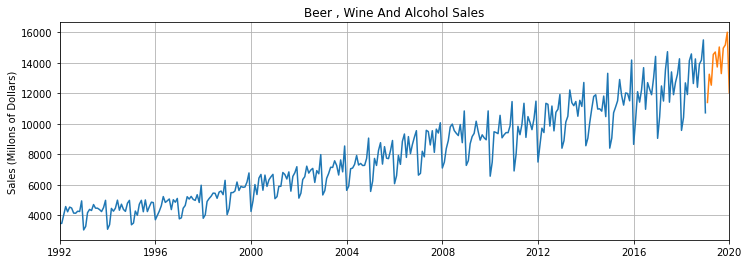

In [61]:
x = np.arange("2019-02-01","2020-02-01", dtype ="datetime64[M]").astype("datetime64")

plt.figure(figsize = (12,4))
plt.title("Beer , Wine And Alcohol Sales")
plt.ylabel("Sales (Millons of Dollars)")
plt.grid(True)
plt.autoscale(axis = "x",tight=True)

plt.plot(df.iloc[:,0])
plt.plot(x,true_predictions[window_size:])
plt.show()

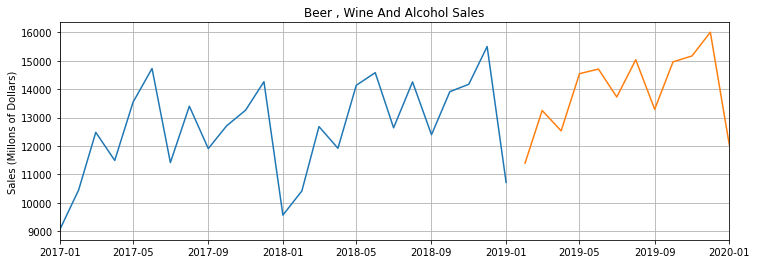

In [62]:
x = np.arange("2019-02-01","2020-02-01", dtype ="datetime64[M]").astype("datetime64")

plt.figure(figsize = (12,4))
plt.title("Beer , Wine And Alcohol Sales")
plt.ylabel("Sales (Millons of Dollars)")
plt.grid(True)
plt.autoscale(axis = "x",tight=True)

plt.plot(df.iloc[:,0]["2017-01-01":])
plt.plot(x,true_predictions[window_size:])
plt.show()